In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [2]:
!pip install "tf-models-official==2.13.*"

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import requests as rq

from io import BytesIO


tf.get_logger().setLevel('ERROR')

In [4]:
url1 = "https://github.com/Taichi22/CollegeCode/raw/main/CSE480/NIHMS1911044-supplement-1%20(2).xlsx"
data = rq.get(url1).content
df_1 = pd.read_excel(BytesIO(data), header=1)
url2 = "https://github.com/Taichi22/CollegeCode/raw/main/CSE480/NIHMS1911044-supplement-2.csv"
data = rq.get(url2).content
ai_generated = pd.read_csv(BytesIO(data))
df_1.head(5)

,Date,Volume,Issue,Number,Article Title,File Name,ChatGPT Question with Title,ChatGPT Question with Human-Derived Phrase,Link Name,Links,Column1
0,90222,377,6610,1,Boosting cognition with a hormone,SciPer1,Can you produce a 300 to 400 word summary on t...,Can you produce a 300 to 400 word summary on t...,Boosting cognition with a hormone | Science,https://www.science.org/doi/10.1126/science.ad...,"As more women conceive later in life, the risk..."
1,90222,377,6610,2,A mosaic of new and old cell types,SciPer2,Can you produce a 300 to 400 word summary on t...,Can you produce a 300 to 400 word summary on t...,A mosaic of new and old cell types | Science,https://www.science.org/doi/10.1126/science.ad...,"Over the past decade, hundreds of cell types h..."
2,90222,377,6610,3,The “atmosphere” of the human body,SciPer3,Can you produce a 300 to 400 word summary on t...,Can you produce a 300 to 400 word summary on t...,The “atmosphere” of the human body | Science,https://www.science.org/doi/10.1126/science.ad...,The human body is a factory for a variety of c...
3,90222,377,6610,4,3D-printing nanocrystals with light,SciPer4,Can you produce a 300 to 400 word summary on t...,Can you produce a 300 to 400 word summary on t...,3D-printing nanocrystals with light | Science,https://www.science.org/doi/10.1126/science.ad...,The ability to fabricate custom three-dimensio...
4,90222,377,6610,5,Foreseeing metal failure from its inception,SciPer5,Can you produce a 300 to 400 word summary on t...,Can you produce a 300 to 400 word summary on t...,Foreseeing metal failure from its inception | ...,https://www.science.org/doi/10.1126/science.ad...,"In 1842, the axle of a locomotive traveling be..."


In [5]:
url3 = "https://github.com/Taichi22/CollegeCode/blob/aed0d810fb7c6b1a9d360f3840fd6e084e4c7418/CSE480/responses.csv"
data = rq.get(url3).content
data_aug = pd.read_csv(BytesIO(data))

data_aug = pd.concat([data_aug['prompt'], data_aug['value'], data_aug['value'].str.split('\n\n', expand=True)], axis=1).copy()
data_aug.columns = data_aug.columns.map(str)
data_aug['Label'] = 1
data_aug.head(1)

,prompt,value,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Label
0,Can you produce a 300 to 400 word summary on t...,Boosting Cognition with a Hormone: A Promising...,Boosting Cognition with a Hormone: A Promising...,"Cognitive performance, including memory, atten...",One hormone that has garnered attention for it...,Research has demonstrated that cortisol can en...,Another hormone that has shown promise in boos...,The use of hormone-based cognitive enhancement...,"In conclusion, research exploring the use of h...",None,None,None,None,None,None,None,None,1


In [24]:
original_papers = pd.concat([df_1['Number'],df_1['File Name'], df_1['Column1'].str.split('\n', expand=True)], axis=1).copy()
original_papers.columns = original_papers.columns.map(str)
original_papers['Label'] = 0
original_papers.head(1)

,Number,File Name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,Label
0,1,SciPer1,"As more women conceive later in life, the risk...",Down syndrome is characterized by cognitive di...,"Throughout life, GnRH release onto the pituita...",The capacity of pulsatile GnRH to enhance cogn...,These unexpected findings of the cognition-boo...,Reduced reproductive function later in life is...,None,None,None,None,None,None,None,None,None,None,None,0


In [7]:
to_melt = pd.concat([original_papers, data_aug])
to_melt.tail(1)

,Number,File Name,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,Label,prompt,value
123,NaN,NaN,Enzyme Formation by Immune Receptors: A Synopsis,The immune system is a complex network of cell...,One prominent example of enzyme formation by i...,Another group of immune receptors that possess...,"Additionally, certain immune receptors exhibit...","In summary, immune receptors, particularly Tol...",None,None,...,None,None,None,None,None,NaN,NaN,1,Can you produce a 300 to 400 word summary on t...,Enzyme Formation by Immune Receptors: A Synops...


In [8]:
# Melt the DataFrame to stack all paragraph columns into single column rows
values = [str(i) for i in range(0,17)]
print(values)
melted_df = pd.melt(to_melt, id_vars=['File Name', 'Label'], value_vars=values)
melted_df = melted_df[melted_df['value'].notna()]
# melted_df.sort_values(by=["Unnamed: 0", 'variable'], inplace=True)
# melted_df['Label'] = 0

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']


<ipython-input-8-ffb31437efff>:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted_df = pd.melt(to_melt, id_vars=['File Name', 'Label'], value_vars=values)


In [9]:
# Split the paragraph text into words and expand to columns
words_df = melted_df['value'].str.split(' ', expand=True)
melted_df = pd.concat([melted_df, words_df], axis=1)

melted_df.columns = melted_df.columns.map(str)

melted_df = melted_df.reindex(axis='index')

melted_df.tail(5)

,File Name,Label,variable,value,0,1,2,3,4,5,...,720,721,722,723,724,725,726,727,728,729
3742,NaN,1,14,The Siberian wildfires are an intricate conseq...,The,Siberian,wildfires,are,an,intricate,...,None,None,None,None,None,None,None,None,None,None
3747,NaN,1,14,The therapeutic potential of psychedelics offe...,The,therapeutic,potential,of,psychedelics,offers,...,None,None,None,None,None,None,None,None,None,None
3906,SciPer94,0,15,This would explain the extraordinary preponder...,This,would,explain,the,extraordinary,preponderance,...,None,None,None,None,None,None,None,None,None,None
3916,SciPer101,0,15,Other open questions about the rapidly develop...,Other,open,questions,about,the,rapidly,...,None,None,None,None,None,None,None,None,None,None
4170,SciPer101,0,16,Availability of a COVID-19 vaccine will initia...,Availability,of,a,COVID-19,vaccine,will,...,None,None,None,None,None,None,None,None,None,None


In [10]:
ai_generated.head(20)
ai_generated['value'] = pd.Series(ai_generated[[str(i) for i in range(1,300)]].fillna('').values.tolist()).str.join(' ')
ai_generated["Label"] = 1
ai_generated.head(20)

,Unnamed: 0,Key,1,2,3,4,5,6,7,8,...,293,294,295,296,297,298,299,300,value,Label
0,1,SciPer01GPH,Gonadotropin-releasing,hormone,(GnRH),is,a,neuropeptide,that,plays,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gonadotropin-releasing hormone (GnRH) is a neu...,1
1,2,SciPer01GPH,Animal,studies,have,provided,evidence,that,GnRH,can,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Animal studies have provided evidence that GnR...,1
2,3,SciPer01GPH,There,is,also,evidence,from,human,studies,that,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,There is also evidence from human studies that...,1
3,4,SciPer01GPH,The,mechanisms,by,which,GnRH,may,improve,cognitive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The mechanisms by which GnRH may improve cogni...,1
4,5,SciPer01GPH,"Overall,",the,research,on,GnRH,and,cognition,is,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Overall, the research on GnRH and cognition is...",1
5,6,SciPer01GPT,"Cognition,",the,mental,process,of,acquiring,knowledge,and,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cognition, the mental process of acquiring kno...",1
6,7,SciPer01GPT,One,hormone,that,has,received,considerable,attention,in,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One hormone that has received considerable att...,1
7,8,SciPer01GPT,Another,hormone,that,has,been,investigated,for,its,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Another hormone that has been investigated for...,1
8,9,SciPer01GPT,Studies,have,also,investigated,the,potential,of,testosterone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Studies have also investigated the potential o...,1
9,10,SciPer01GPT,While,the,potential,of,these,hormones,for,boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,While the potential of these hormones for boos...,1


In [11]:
ai_text = ai_generated[["Label", "value"]]
ai_text = tf.data.Dataset.from_tensor_slices(dict(ai_text))
for feature_batch in ai_text.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

ai_concat_list = [str(i) for i in range(1,301)]
ai_concat_list.append("Label")
ai_concat_list.append("value")
ai_concat_df = ai_generated[ai_concat_list]

human_concat_list = [str(i) for i in range(1,730)]
human_concat_list.append("Label")
human_concat_list.append("value")
melted_concat_df = melted_df[human_concat_list]

melted_concat_df.head(5)

  'Label'             : 1
  'value'             : b'Gonadotropin-releasing hormone (GnRH) is a neuropeptide that plays a key role in the regulation of reproductive function. However, recent studies have suggested that GnRH may also have a positive effect on cognitive function. Research has shown that GnRH receptors are present in regions of the brain that are involved in cognitive processing, including the hippocampus, amygdala, and prefrontal cortex.                                                                                                                                                                                                                                                '


,1,2,3,4,5,6,7,8,9,10,...,722,723,724,725,726,727,728,729,Label,value
0,more,women,conceive,later,in,"life,",the,risk,of,having,...,None,None,None,None,None,None,None,None,0,"As more women conceive later in life, the risk..."
1,the,past,"decade,",hundreds,of,cell,types,have,been,identified,...,None,None,None,None,None,None,None,None,0,"Over the past decade, hundreds of cell types h..."
2,human,body,is,a,factory,for,a,variety,of,chemicals,...,None,None,None,None,None,None,None,None,0,The human body is a factory for a variety of c...
3,ability,to,fabricate,custom,three-dimensional,(3D),objects,on,demand,has,...,None,None,None,None,None,None,None,None,0,The ability to fabricate custom three-dimensio...
4,"1842,",the,axle,of,a,locomotive,traveling,between,Versailles,and,...,None,None,None,None,None,None,None,None,0,"In 1842, the axle of a locomotive traveling be..."


In [12]:
all_text = pd.concat([ai_concat_df, melted_concat_df])
all_text.head(20)

,1,2,3,4,5,6,7,8,9,10,...,720,721,722,723,724,725,726,727,728,729
0,Gonadotropin-releasing,hormone,(GnRH),is,a,neuropeptide,that,plays,a,key,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Animal,studies,have,provided,evidence,that,GnRH,can,improve,cognitive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,There,is,also,evidence,from,human,studies,that,suggests,that,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The,mechanisms,by,which,GnRH,may,improve,cognitive,function,are,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Overall,",the,research,on,GnRH,and,cognition,is,still,in,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Cognition,",the,mental,process,of,acquiring,knowledge,and,understanding,through,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,One,hormone,that,has,received,considerable,attention,in,this,regard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Another,hormone,that,has,been,investigated,for,its,cognitive,effects,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Studies,have,also,investigated,the,potential,of,testosterone,for,boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,While,the,potential,of,these,hormones,for,boosting,cognition,is,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
all_text['Label']

0       1
1       1
2       1
3       1
4       1
       ..
3742    1
3747    1
3906    0
3916    0
4170    0
Name: Label, Length: 2660, dtype: int64

In [14]:
import re

# Helper function to count occurrences
def count_occurrences(pattern, row, fixed=False, matchCase=True, verbose = False):
    if matchCase:
      if fixed:
        if verbose:
          print(row.str.count(re.escape(pattern)))
        return row.str.count(re.escape(pattern))
      else:
        if verbose:
          print(row.str.count(pattern))
        return row.str.count(pattern)
    else:
      lcase = pattern.lower()
      lseries = row.str.lower()
      if fixed:
          return lseries.str.count(re.escape(lcase))
      else:
          return lseries.str.count(lcase)

wordindex = [str(i) for i in range(1, 301)]

# V1: Count of "."
V1 = np.asarray([np.sum(count_occurrences(".", row[wordindex], fixed=True)) for index, row in all_text.iterrows()])

# V2: Count of non-NA entries
V2 = all_text.notna().sum(axis=1)

# V3: Presence of ")"
V3 = np.asarray([np.sum(count_occurrences(")", row[wordindex], fixed=True)) > 0 for index, row in all_text.iterrows()]).astype(int)

# V4: Presence of "-"
V4 = np.asarray([np.sum(count_occurrences("-", row[wordindex])) > 0 for index, row in all_text.iterrows()]).astype(int)

# V5: Presence of ";" or ":"
V5 = np.asarray([np.sum(count_occurrences(";", row[wordindex]) + count_occurrences(":", row[wordindex])) > 0 for index, row in all_text.iterrows()]).astype(int)

# V6: Presence of "?"
V6 = np.asarray([np.sum(count_occurrences("\\?", row[wordindex])) > 0 for index, row in all_text.iterrows()]).astype(int)

# V7: Presence of "'"
V7 = np.asarray([np.sum(count_occurrences("'", row[wordindex])) > 0 for index, row in all_text.iterrows()]).astype(int)

sentence_lengths = []
sentence_diffs = []
sentences11 = []
sentences34 = []

# Iterate over each row in the DataFrame
for index, row in all_text.iterrows():
  sentence_length = 0
  rowlengths = []
  rowdiffs = []
  previous_sentence_end = -1
  count11 = 0
  count34 = 0
  # Iterate over each word in the row
  for col, word in enumerate(row[wordindex]):
      if pd.notna(word):  # Check if the word cell is not NaN
          sentence_length += 1
          if '.' in word:
              # Sentence ended, process the sentence length
              rowlengths.append(sentence_length)

              # Calculate the difference in length with the previous sentence
              if previous_sentence_end != -1:
                  sentence_diff = sentence_length - previous_sentence_end
                  rowdiffs.append(sentence_diff)
              previous_sentence_end = sentence_length

              # Check if the sentence length is less than 11 or greater than 34
              if sentence_length < 11:
                  count11 += 1
              elif sentence_length > 34:
                  count34 += 1
              # Reset the sentence length for the next sentence
              sentence_length = 0
  sentences11.append(count11)
  sentences34.append(count34)
  sentence_lengths.append(rowlengths)
  sentence_diffs.append(rowdiffs)

# Calculate V8, V9, V10, V11 based on the lists generated above
V8 = np.array([np.std(x) for x in sentence_lengths])  # Standard deviation in sentence length
V9 = np.array([np.mean(x) for x in sentence_diffs]) # Mean of length differences for consecutive sentences
V10 = sentences11    # Number of sentences with <11 words
V11 = sentences34     # Number of sentences with >34 words

V8[np.isnan(V8)] = 0
V9[np.isnan(V9)] = 0

# V12 to V18: Specific word and pattern counts
words_to_count = ["although", "However", "but", "because", "this"]
V12 = np.asarray([np.sum(count_occurrences("although", row[wordindex], matchCase=False)) > 0 for index, row in all_text.iterrows()]).astype(int)
V13 = np.asarray([np.sum(count_occurrences("However", row[wordindex], matchCase=False)) > 0 for index, row in all_text.iterrows()]).astype(int)
V14 = np.asarray([np.sum(count_occurrences("but", row[wordindex], matchCase=False)) > 0 for index, row in all_text.iterrows()]).astype(int)
V15 = np.asarray([np.sum(count_occurrences("because", row[wordindex], matchCase=False)) > 0 for index, row in all_text.iterrows()]).astype(int)
V16 = np.asarray([np.sum(count_occurrences("this", row[wordindex], matchCase=False)) > 0 for index, row in all_text.iterrows()]).astype(int)
V17 = np.asarray([np.sum(count_occurrences("others", row[wordindex], matchCase=False)) + np.sum(count_occurrences("researchers", row[wordindex], matchCase=False)) > 0 for index, row in all_text.iterrows()]).astype(int)
V18 = np.asarray([np.sum(count_occurrences("[0-9]", row[wordindex])) > 0 for index, row in all_text.iterrows()]).astype(int)


# V19: Proportion of capitalized words
capitals = np.asarray([np.sum(count_occurrences("[A-Z]", row[wordindex])) for index, row in all_text.iterrows()]).astype(int)

V19 = np.asarray([np.sum(count_occurrences("[A-Z]", row[wordindex])) for index, row in all_text.iterrows()]).astype(int) >= V1 * 2

# V20: Presence of "et"
V20 = np.asarray([np.sum(count_occurrences("et", row[wordindex], matchCase=False)) > 0 for index, row in all_text.iterrows()]).astype(int)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
# Combine all features into a DataFrame
feature_df = pd.DataFrame({
    'V1': V1,
    'V2': V2,
    'V3': V3,
    'V4': V4,
    'V5': V5,
    'V6': V6,
    'V7': V7,
    'V8': V8,
    'V9': V9,
    'V10': V10,
    'V11': V11,
    'V12': V12,
    'V13': V13,
    'V14': V14,
    'V15': V15,
    'V16': V16,
    'V17': V17,
    'V18': V18,
    'V19': V19,
    'V20': V20
})
pd.options.display.max_columns = None
pd.options.display.max_rows = None
feature_df.head(15)
df = pd.concat([feature_df, all_text[['value', 'Label']]], axis=1)
df['V19'] = df['V19'].astype(int)
df.head(15)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,value,Label
0,3.0,61,1,1,0,0,0,4.496913,4.500000,0,0,0,1,0,0,0,0,0,1,0,Gonadotropin-releasing hormone (GnRH) is a neu...,1
1,3.0,64,0,1,0,0,0,3.299832,3.500000,0,0,0,0,0,0,0,0,0,1,1,Animal studies have provided evidence that GnR...,1
2,3.0,58,0,0,0,0,0,2.624669,3.000000,0,0,0,0,0,0,0,0,0,1,1,There is also evidence from human studies that...,1
3,2.0,49,0,0,0,0,0,9.500000,19.000000,0,0,0,1,0,0,0,0,0,1,1,The mechanisms by which GnRH may improve cogni...,1
4,2.0,56,0,0,0,0,1,0.000000,0.000000,0,0,0,1,0,0,0,0,0,1,0,"Overall, the research on GnRH and cognition is...",1
5,3.0,55,0,1,0,0,0,2.867442,-1.500000,0,0,0,0,0,0,0,1,0,0,1,"Cognition, the mental process of acquiring kno...",1
6,5.0,86,0,0,0,0,1,4.707441,3.250000,0,0,0,1,0,0,1,0,0,0,1,One hormone that has received considerable att...,1
7,4.0,65,0,0,0,0,0,2.487469,2.000000,0,0,0,1,0,0,0,0,0,0,0,Another hormone that has been investigated for...,1
8,3.0,60,0,1,0,0,0,6.548961,8.000000,0,0,0,0,1,0,0,0,0,0,0,Studies have also investigated the potential o...,1
9,4.0,60,0,1,0,0,0,4.555217,-4.000000,1,0,0,0,0,0,0,0,0,0,1,While the potential of these hormones for boos...,1


In [16]:
train, test = train_test_split(df, stratify = df["Label"], test_size=0.2, random_state=42)
train, val = train_test_split(df, stratify = df["Label"], test_size=0.1, random_state=42)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 4
seed = 12

generated_vars = ['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V19']

train_text_ds = tf.data.Dataset.from_tensor_slices(train[["value"]])
train_meta_ds = tf.data.Dataset.from_tensor_slices(train[generated_vars])
train_labels_ds = tf.data.Dataset.from_tensor_slices(train[['Label']])
combined_train_ds = tf.data.Dataset.zip(((train_text_ds, train_meta_ds), train_labels_ds))

combined_train_ds = combined_train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

test_text_ds = tf.data.Dataset.from_tensor_slices(test[["value"]])
test_meta_ds = tf.data.Dataset.from_tensor_slices(test[generated_vars])
test_labels_ds = tf.data.Dataset.from_tensor_slices(test[['Label']])
combined_test_ds = tf.data.Dataset.zip(((test_text_ds, test_meta_ds), test_labels_ds))

combined_test_ds = combined_test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


val_text_ds = tf.data.Dataset.from_tensor_slices(val[["value"]])
val_meta_ds = tf.data.Dataset.from_tensor_slices(val[generated_vars])
val_labels_ds = tf.data.Dataset.from_tensor_slices(val[['Label']])
combined_val_ds = tf.data.Dataset.zip(((val_text_ds, val_meta_ds), val_labels_ds))

combined_val_ds = combined_val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


In [18]:
# for data, labels in combined_train_ds.take(1):
#     print("Labels:", labels)

In [19]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [20]:
import tensorflow as tf
import tensorflow_hub as hub

def build_classifier_model_with_metadata(metadata_shape):
    # Text input (as before)
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # BERT preprocessing and encoder layers (as before)
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    encoder_inputs = preprocessing_layer(text_input)
    outputs = encoder(encoder_inputs)

    # BERT pooled output
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    # net = tf.keras.layers.Flatten()(net)
    # Additional input for metadata
    metadata_input = tf.keras.layers.Input(shape=metadata_shape, name='metadata')

    # Optionally, add a layer to process metadata
    metadata_processed = tf.keras.layers.Dense(16, activation='relu')(metadata_input)
    metadata_processed = tf.keras.layers.Flatten()(metadata_processed)

    # Combine BERT output with metadata
    combined = tf.keras.layers.Concatenate()([net, metadata_processed])
    # Final classifier layer
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(combined)
    print("Shape after Dense layer:", net.shape)
    # Create the model
    return tf.keras.Model(inputs=[text_input, metadata_input], outputs=net)

# Example usage

model = build_classifier_model_with_metadata(train[['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V19']].shape[1])
model.summary()

Shape after Dense layer: (None, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                           

In [21]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(combined_train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

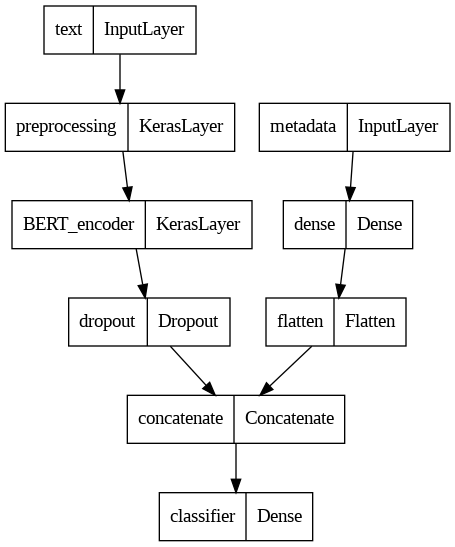

In [22]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
tf.keras.utils.plot_model(model)

In [23]:
history = model.fit(x=combined_train_ds, validation_data=combined_val_ds, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


599/599 [==============================] - 50s 70ms/step - loss: 0.2420 - binary_accuracy: 0.9206 - val_loss: 0.3805 - val_binary_accuracy: 0.9398


KeyboardInterrupt: ignored

In [ ]:
loss, accuracy = model.evaluate(combined_test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [ ]:

y_pred = ((model.predict(combined_test_ds)) > 0.5).astype('int32')

y_true = np.concatenate([y for x, y in combined_test_ds], axis=0)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_true, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
import json
import time
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
str(time.time)
json.dump(history_dict, open('ensemble_history_' + time.strftime("%a, %d %b %Y %H:%M:%S", time.gmtime()) + '.json', 'w'))

In [ ]:
BERT_history = json.load(open('BERT_history.json', 'r'))

In [ ]:
history_dict = history.history
BERT_dict = BERT_history
print(history_dict.keys())
print(BERT_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

BERT_acc = BERT_dict['binary_accuracy']
BERT_val_acc = BERT_dict['val_binary_accuracy']
BERT_loss = BERT_dict['loss']
BERT_val_loss = BERT_dict['val_loss']


epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, BERT_loss, 'r--', label='Training loss (BERT)')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, BERT_val_loss, 'b--', label='Validation loss (BERT)')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, BERT_acc, 'r--', label='Training acc (BERT)')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, BERT_val_acc, 'b--', label='Validation acc (BERT)')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')